# Imports

In [1]:
config = {
    'dhdt': {
        'depth': 3,
        'learning_rate': 0.0001,#1e-3,
        
        'initializer': 'he_normal', #GlorotUniform
        'initializer_index': 'ones', #GlorotUniform
        
        
        'loss': 'binary_crossentropy',#'mae',
        'optimizer': 'adam',        
        
        'beta_1': 7,
        'beta_2': 12,
        
        'activation': 'tanh', #sigmoid
        'squeeze_factor': 1.5,
        
        'batch_size': 512,
        'epochs': 100_000,
        'early_stopping_epochs': 50,
    },
    
    
    
    'make_classification': {
        'number_of_variables': 20,
        'n_samples': 5_000,
        'num_eval': 10,
        'noise': 0.1,
    },

    'computation': {
        'random_seed': 42,
        'trials': 5,
        'n_jobs': 50,
        'verbosity': 0,
    },
}



In [2]:
import numpy as np
np.set_printoptions(suppress=True)

import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder

from livelossplot import PlotLosses

import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from IPython.display import Image
from IPython.display import display, clear_output

import pandas as pd

os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = '' #'true'

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging

import tensorflow as tf
import tensorflow_addons as tfa

tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

np.seterr(all="ignore")

from keras import backend as K
from keras.utils.generic_utils import get_custom_objects


import seaborn as sns
sns.set_style("darkgrid")

import time
import random

from utilities.utilities import *
from utilities.DHDT import *

from joblib import Parallel, delayed

from itertools import product
from collections.abc import Iterable

from copy import deepcopy

tf.random.set_seed(config['computation']['random_seed'])
np.random.seed(config['computation']['random_seed'])
random.seed(config['computation']['random_seed'])

# Evaluation

## make_classification

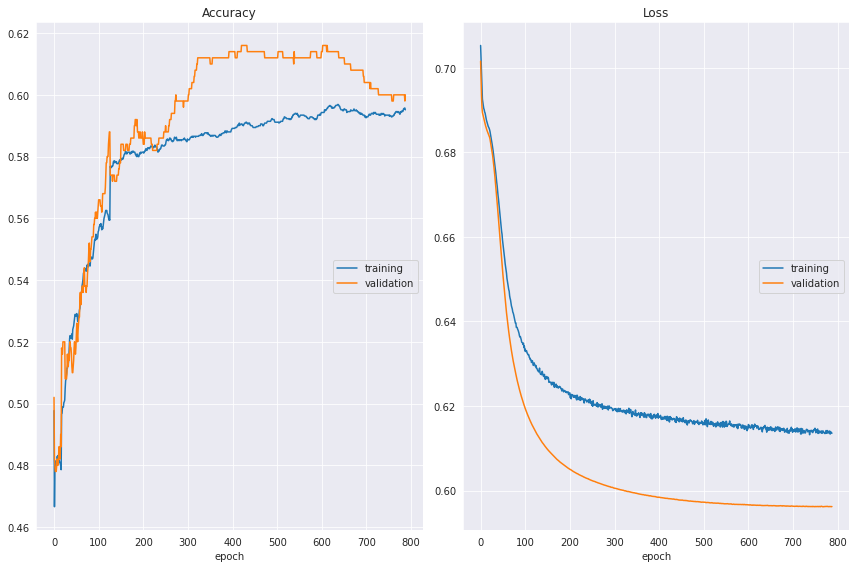

Accuracy
	training         	 (min:    0.467, max:    0.597, cur:    0.595)
	validation       	 (min:    0.478, max:    0.616, cur:    0.600)
Loss
	training         	 (min:    0.613, max:    0.705, cur:    0.614)
	validation       	 (min:    0.596, max:    0.702, cur:    0.596)
Test accuracy Sklearn (0) 0.616
Test accuracy DHDT (0) 0.616
________________________________________________________________________________________________________
Test f1 Sklearn (0) 0.6041237113402063
Test f1 DHDT (0) 0.6867862969004894
________________________________________________________________________________________________________


In [3]:
if True:
    tf.random.set_seed(config['computation']['random_seed'])
    np.random.seed(config['computation']['random_seed'])
    random.seed(config['computation']['random_seed'])  
    
    metrics = ['accuracy', 'f1']
    
    config_test = deepcopy(config)
    #config_test['make_classification']['n_samples'] = 10_000
    #config_test['dhdt']['epochs'] = 50
    #config_test['dhdt']['initializer_index'] = 'he_normal'#'ones', #GlorotUniform
    #config_test['dhdt']['activation'] = 'sigmoid'

    dataset_dict = {}
    model_dict = {}

    scores_dict = {'sklearn': {},
                   'DHDT': {}}
    
    dataset_dict = get_preprocessed_dataset('make_classification',
                                            random_seed=config_test['computation']['random_seed'],
                                            config=config_test['make_classification'],
                                            verbosity=2)

    model_dict['sklearn'] = DecisionTreeClassifier(max_depth=3, 
                                                   random_state=config_test['computation']['random_seed'])

    model_dict['sklearn'].fit(dataset_dict['X_train'], 
                              dataset_dict['y_train'])



    model_dict['DHDT'] = DHDT(dataset_dict['X_train'].shape[1],

                                depth = config_test['dhdt']['depth'],

                                learning_rate = config_test['dhdt']['learning_rate'],
                                optimizer = config_test['dhdt']['optimizer'],
                              
                                initializer = config_test['dhdt']['initializer'],
                                initializer_index = config_test['dhdt']['initializer_index'],
                              
                                beta_1 = config_test['dhdt']['beta_1'],
                                beta_2 = config_test['dhdt']['beta_2'],

                                activation = config_test['dhdt']['activation'],
                                squeeze_factor = config_test['dhdt']['squeeze_factor'],

                                loss = config_test['dhdt']['loss'],#'mae',

                                random_seed = config_test['computation']['random_seed'],
                                verbosity = 1)#5        


    scores_dict['history'] = model_dict['DHDT'].fit(dataset_dict['X_train'], 
                                                  dataset_dict['y_train'], 
                                                  batch_size=config_test['dhdt']['batch_size'], 
                                                  epochs=config_test['dhdt']['epochs'], 
                                                  early_stopping_epochs=config_test['dhdt']['early_stopping_epochs'], 
                                                  valid_data=(dataset_dict['X_valid'], dataset_dict['y_valid']))


    dataset_dict['y_test_dhdt'] = model_dict['DHDT'].predict(dataset_dict['X_test'])
    dataset_dict['y_valid_dhdt'] = model_dict['DHDT'].predict(dataset_dict['X_valid'])

    dataset_dict['y_test_sklearn'] = model_dict['sklearn'].predict(dataset_dict['X_test'])
    dataset_dict['y_valid_sklearn'] = model_dict['sklearn'].predict(dataset_dict['X_valid'])     
    
    for metric in metrics:
        
        if metric in ['accuracy', 'f1']:
            y_test_dhdt = np.round(dataset_dict['y_test_dhdt'])
            y_valid_dhdt = np.round(dataset_dict['y_valid_dhdt'])
            y_test_sklearn = np.round(dataset_dict['y_test_sklearn'])
            y_valid_sklearn = np.round(dataset_dict['y_valid_sklearn'])         
        else:
            y_test_dhdt = dataset_dict['y_test_dhdt']
            y_valid_dhdt = dataset_dict['y_valid_dhdt']
            y_test_sklearn = dataset_dict['y_test_sklearn']
            y_valid_sklearn =    dataset_dict['y_valid_sklearn']                
        
        scores_dict['sklearn'][metric + '_test'] = sklearn.metrics.get_scorer(metric)._score_func(dataset_dict['y_test'], y_test_sklearn)
        scores_dict['DHDT'][metric + '_test'] = sklearn.metrics.get_scorer(metric)._score_func(dataset_dict['y_test'], y_test_dhdt)

        scores_dict['sklearn'][metric + '_valid'] = sklearn.metrics.get_scorer(metric)._score_func(dataset_dict['y_valid'], y_valid_sklearn)   
        scores_dict['DHDT'][metric + '_valid'] = sklearn.metrics.get_scorer(metric)._score_func(dataset_dict['y_valid'], y_valid_dhdt)

        print('Test ' + metric + ' Sklearn (' + str(0) + ')', scores_dict['sklearn'][metric + '_test'])
        print('Test ' + metric + ' DHDT (' + str(0) + ')', scores_dict['DHDT'][metric + '_test'])   
        print('________________________________________________________________________________________________________')   


In [4]:
if False:    
    plt.figure(figsize=(15,8))
    image = model_dict['DHDT'].plot()
    display(image)

    plt.figure(figsize=(15,8))
    plot_tree(model_dict['sklearn'], fontsize=10) 
    plt.show()

In [5]:
if False:    
    plt.figure(figsize=(15,8))
    image = model_dict['DHDT'].plot(normalizer_list=dataset_dict['normalizer_list'])
    display(image)

    plt.figure(figsize=(15,8))
    plot_tree(model_dict['sklearn'], fontsize=10) 
    plt.show()

In [6]:
if True:
    parallel_eval_synthetic = Parallel(n_jobs=config['computation']['n_jobs'], verbose=3, backend='loky') #loky #sequential multiprocessing
    evaluation_results_synthetic = parallel_eval_synthetic(delayed(evaluate_synthetic_parallel)(index = index,
                                                                                                random_seed_data = config['computation']['random_seed']+index,
                                                                                                random_seed_model = config['computation']['random_seed'],#+random_seed_model,
                                                                                                config = config,
                                                                                                verbosity = -1) for index in range(config['make_classification']['num_eval']))

    for i, synthetic_result in enumerate(evaluation_results_synthetic):
        if i == 0:
            model_dict_synthetic = synthetic_result[0]
            scores_dict_synthetic = synthetic_result[1]
            dataset_dict_synthetic = synthetic_result[2]
        else: 
            model_dict_synthetic = mergeDict(model_dict_synthetic, synthetic_result[0])
            scores_dict_synthetic = mergeDict(scores_dict_synthetic, synthetic_result[1])
            dataset_dict_synthetic = mergeDict(dataset_dict_synthetic, synthetic_result[2])        
    
    metric_identifer = '_test'
    metrics = ['accuracy', 'f1']
    index = [i for i in range(config['make_classification']['num_eval'])]
    columns = flatten_list([[[approach + ' ' + metric + '_mean', approach + ' ' + metric + '_max', approach + ' ' + metric + '_std'] for metric in metrics] for approach in ['DHDT', 'sklearn']])


    results_DHDT = None
    results_sklearn = None
    for metric in metrics:
        scores_DHDT = [scores_dict_synthetic[i]['DHDT'][metric + metric_identifer] for i in range(config['make_classification']['num_eval'])]

        scores_sklearn = [scores_dict_synthetic[i]['sklearn'][metric + metric_identifer] for i in range(config['make_classification']['num_eval'])]

        scores_DHDT_mean = np.mean(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else scores_DHDT
        scores_sklearn_mean = np.mean(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else scores_sklearn

        scores_DHDT_max = np.max(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else scores_DHDT
        scores_sklearn_max = np.max(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else scores_sklearn

        scores_DHDT_std = np.std(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else np.array([0.0] * config['computation']['trials'])
        scores_sklearn_std = np.std(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else np.array([0.0] * config['computation']['trials'])

        results_DHDT_by_metric = np.vstack([scores_DHDT_mean, scores_DHDT_max, scores_DHDT_std])
        results_sklearn_by_metric = np.vstack([scores_sklearn_mean, scores_sklearn_max, scores_sklearn_std])

        if results_DHDT is None and results_sklearn is None:
            results_DHDT = results_DHDT_by_metric
            results_sklearn = results_sklearn_by_metric
        else:
            results_DHDT = np.vstack([results_DHDT, results_DHDT_by_metric])
            results_sklearn = np.vstack([results_sklearn, results_sklearn_by_metric])

    scores_dataframe_synthetic = pd.DataFrame(data=np.vstack([results_DHDT, results_sklearn]).T, index = index, columns = columns)    
        
    index = [index_name.split(' ')[1] for index_name in scores_dataframe_synthetic.mean()[scores_dataframe_synthetic.shape[1]//2:].index]
    mean_result_dataframe_synthetic = np.round(pd.DataFrame(data=np.vstack([scores_dataframe_synthetic.mean()[:scores_dataframe_synthetic.shape[1]//2], scores_dataframe_synthetic.mean()[scores_dataframe_synthetic.shape[1]//2:]]).T, index=index, columns=['DHDT', 'sklearn']), 3)

        
    display(scores_dataframe_synthetic.head(5))
    display(scores_dataframe_synthetic[scores_dataframe_synthetic.columns[0::3]].iloc[:,[0,2,1,3]].head(5))
    display(scores_dataframe_synthetic[scores_dataframe_synthetic.columns[1::3]].iloc[:,[0,2,1,3]].head(5))
    display(mean_result_dataframe_synthetic)
    

[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   3 out of  10 | elapsed:  4.4min remaining: 10.3min
[Parallel(n_jobs=50)]: Done   7 out of  10 | elapsed:  5.3min remaining:  2.3min
[Parallel(n_jobs=50)]: Done  10 out of  10 | elapsed:  5.8min finished


,DHDT accuracy_mean,DHDT accuracy_max,DHDT accuracy_std,DHDT f1_mean,DHDT f1_max,DHDT f1_std,sklearn accuracy_mean,sklearn accuracy_max,sklearn accuracy_std,sklearn f1_mean,sklearn f1_max,sklearn f1_std
0,0.5812,0.609,0.019539,0.533651,0.656716,0.108219,0.6218,0.645,0.0116,0.623685,0.701931,0.039123
1,0.6104,0.639,0.018029,0.576736,0.674720,0.091780,0.6390,0.640,0.0020,0.602710,0.642507,0.019899
2,0.6792,0.728,0.025561,0.687113,0.725806,0.039792,0.7698,0.775,0.0104,0.771303,0.777448,0.012291
3,0.6956,0.746,0.050038,0.699142,0.766696,0.055887,0.7728,0.799,0.0524,0.770553,0.809479,0.077852
4,0.6266,0.651,0.022285,0.618355,0.706476,0.049835,0.6776,0.748,0.0352,0.687007,0.763158,0.038076


,DHDT accuracy_mean,sklearn accuracy_mean,DHDT f1_mean,sklearn f1_mean
0,0.5812,0.6218,0.533651,0.623685
1,0.6104,0.6390,0.576736,0.602710
2,0.6792,0.7698,0.687113,0.771303
3,0.6956,0.7728,0.699142,0.770553
4,0.6266,0.6776,0.618355,0.687007


,DHDT accuracy_max,sklearn accuracy_max,DHDT f1_max,sklearn f1_max
0,0.609,0.645,0.656716,0.701931
1,0.639,0.640,0.674720,0.642507
2,0.728,0.775,0.725806,0.777448
3,0.746,0.799,0.766696,0.809479
4,0.651,0.748,0.706476,0.763158


,DHDT,sklearn
accuracy_mean,0.641,0.697
accuracy_max,0.685,0.736
accuracy_std,0.033,0.030
f1_mean,0.629,0.687
f1_max,0.702,0.746
f1_std,0.059,0.043


In [7]:
if False:
    plot_index = 0
    
    plt.figure(figsize=(15,8))
    image = model_dict_synthetic[1]['DHDT'][plot_index].plot(normalizer_list=dataset_dict_synthetic[1]['normalizer_list'])
    display(image)

    plt.figure(figsize=(15,8))
    plot_tree(model_dict_synthetic[1]['sklearn'][plot_index], fontsize=10) 
    plt.show()

## Real-World Eval

In [8]:
if True:

    identifier_list = [
                        'Adult',#: 32,
                        'Bank Marketing',#: 32,
                        'Loan Credit',#: 32,

                        'Credit Card',#: 23, 
                        'Car',#: 21,


                        'Absenteeism',#: 15,
                        'Loan House',#: 15,
                        'Cervical Cancer',#: 15,

                        'Heart Disease',#: 13,           

                        'Titanic',#: 10,
                        'Medical Insurance',#: 10,
                        'Wisconsin Breast Cancer Original',#: 10,
                        'Wisconsin Diagnostic Breast Cancer',#: 10,
                        'Wisconsin Prognostic Breast Cancer',#: 10,
                        'Abalone',#: 10,

                        'Habermans Survival',#: 3, 
                      ]
    
    parallel_eval_real_world = Parallel(n_jobs=config['computation']['n_jobs'], verbose=3, backend='loky') #loky #sequential multiprocessing
    evaluation_results_real_world = parallel_eval_real_world(delayed(evaluate_real_world_parallel)(identifier_list=identifier_list, 
                                                                                                   random_seed_model=config['computation']['random_seed']+i,
                                                                                                   config = config,
                                                                                                   verbosity = -1) for i in range(config['computation']['trials']))


    for i, real_world_result in enumerate(evaluation_results_real_world):
        if i == 0:
            model_dict_real_world = real_world_result[0]
            scores_dict_real_world = real_world_result[1]
            dataset_dict_real_world = real_world_result[2]
        else: 
            model_dict_real_world = mergeDict(model_dict_real_world, real_world_result[0])
            scores_dict_real_world = mergeDict(scores_dict_real_world, real_world_result[1])
            dataset_dict_real_world = mergeDict(dataset_dict_real_world, real_world_result[2])    

    metric_identifer = '_test'
    metrics = ['accuracy', 'f1']
    index = identifier_list
    columns = flatten_list([[[approach + ' ' + metric + '_mean', approach + ' ' + metric + '_max', approach + ' ' + metric + '_std'] for metric in metrics] for approach in ['DHDT', 'sklearn']])


    results_DHDT = None
    results_sklearn = None
    for metric in metrics:
        scores_DHDT = [scores_dict_real_world[identifier]['DHDT'][metric + metric_identifer] for identifier in identifier_list]

        scores_sklearn = [scores_dict_real_world[identifier]['sklearn'][metric + metric_identifer] for identifier in identifier_list]    

        scores_DHDT_mean = np.mean(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else scores_DHDT
        scores_sklearn_mean = np.mean(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else scores_sklearn

        scores_DHDT_max = np.max(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else scores_DHDT
        scores_sklearn_max = np.max(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else scores_sklearn

        scores_DHDT_std = np.std(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else np.array([0.0] * config['computation']['trials'])
        scores_sklearn_std = np.std(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else np.array([0.0] * config['computation']['trials'])

        results_DHDT_by_metric = np.vstack([scores_DHDT_mean, scores_DHDT_max, scores_DHDT_std])
        results_sklearn_by_metric = np.vstack([scores_sklearn_mean, scores_sklearn_max, scores_sklearn_std])

        if results_DHDT is None and results_sklearn is None:
            results_DHDT = results_DHDT_by_metric
            results_sklearn = results_sklearn_by_metric
        else:
            results_DHDT = np.vstack([results_DHDT, results_DHDT_by_metric])
            results_sklearn = np.vstack([results_sklearn, results_sklearn_by_metric])
            
    scores_dataframe_real_world = pd.DataFrame(data=np.vstack([results_DHDT, results_sklearn]).T, index = index, columns = columns)
            
    index = [index_name.split(' ')[1] for index_name in scores_dataframe_real_world.mean()[scores_dataframe_real_world.shape[1]//2:].index]
    mean_result_dataframe_real_world = np.round(pd.DataFrame(data=np.vstack([scores_dataframe_real_world.mean()[:scores_dataframe_real_world.shape[1]//2], scores_dataframe_real_world.mean()[scores_dataframe_real_world.shape[1]//2:]]).T, index=index, columns=['DHDT', 'sklearn']), 3)
                
    display(scores_dataframe_real_world)
    display(scores_dataframe_real_world[scores_dataframe_real_world.columns[0::3]].iloc[:,[0,2,1,3]])    
    display(scores_dataframe_real_world[scores_dataframe_real_world.columns[1::3]].iloc[:,[0,2,1,3]])    

    display(mean_result_dataframe_real_world)
    


[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   2 out of   5 | elapsed: 29.5min remaining: 44.2min
[Parallel(n_jobs=50)]: Done   5 out of   5 | elapsed: 39.9min finished


,DHDT accuracy_mean,DHDT accuracy_max,DHDT accuracy_std,DHDT f1_mean,DHDT f1_max,DHDT f1_std,sklearn accuracy_mean,sklearn accuracy_max,sklearn accuracy_std,sklearn f1_mean,sklearn f1_max,sklearn f1_std
Adult,0.666984,0.711302,0.059467,0.559143,0.582408,0.032164,0.815571,0.815571,0.000000e+00,0.646036,0.646036,0.000000e+00
Bank Marketing,0.737182,0.865627,0.098371,0.277479,0.295652,0.011376,0.784672,0.784672,0.000000e+00,0.464374,0.464374,0.000000e+00
Loan Credit,0.448957,0.613251,0.127442,0.407175,0.454036,0.023891,0.712556,0.712556,0.000000e+00,0.460320,0.460320,0.000000e+00
Credit Card,0.782167,0.782667,0.000606,0.877123,0.877292,0.000232,0.776167,0.776167,0.000000e+00,0.855420,0.855420,0.000000e+00
Car,0.778551,0.878261,0.080298,0.695533,0.840909,0.115210,0.898551,0.898551,1.110223e-16,0.841629,0.841629,0.000000e+00
Absenteeism,0.605405,0.635135,0.042218,0.201276,0.477612,0.148468,0.635135,0.635135,0.000000e+00,0.386364,0.386364,0.000000e+00
Loan House,0.757377,0.795082,0.063195,0.833709,0.863388,0.050049,0.762295,0.762295,0.000000e+00,0.837989,0.837989,0.000000e+00
Cervical Cancer,0.798830,0.923977,0.131161,0.065187,0.148148,0.057456,0.467836,0.467836,0.000000e+00,0.116505,0.116505,1.387779e-17
Heart Disease,0.780000,0.850000,0.060919,0.776353,0.842105,0.038817,0.850000,0.850000,0.000000e+00,0.842105,0.842105,0.000000e+00
Titanic,0.752809,0.780899,0.050749,0.654580,0.723404,0.100258,0.797753,0.797753,0.000000e+00,0.735294,0.735294,0.000000e+00


,DHDT accuracy_mean,sklearn accuracy_mean,DHDT f1_mean,sklearn f1_mean
Adult,0.666984,0.815571,0.559143,0.646036
Bank Marketing,0.737182,0.784672,0.277479,0.464374
Loan Credit,0.448957,0.712556,0.407175,0.460320
Credit Card,0.782167,0.776167,0.877123,0.855420
Car,0.778551,0.898551,0.695533,0.841629
Absenteeism,0.605405,0.635135,0.201276,0.386364
Loan House,0.757377,0.762295,0.833709,0.837989
Cervical Cancer,0.798830,0.467836,0.065187,0.116505
Heart Disease,0.780000,0.850000,0.776353,0.842105
Titanic,0.752809,0.797753,0.654580,0.735294


,DHDT accuracy_max,sklearn accuracy_max,DHDT f1_max,sklearn f1_max
Adult,0.711302,0.815571,0.582408,0.646036
Bank Marketing,0.865627,0.784672,0.295652,0.464374
Loan Credit,0.613251,0.712556,0.454036,0.460320
Credit Card,0.782667,0.776167,0.877292,0.855420
Car,0.878261,0.898551,0.840909,0.841629
Absenteeism,0.635135,0.635135,0.477612,0.386364
Loan House,0.795082,0.762295,0.863388,0.837989
Cervical Cancer,0.923977,0.467836,0.148148,0.116505
Heart Disease,0.850000,0.850000,0.842105,0.842105
Titanic,0.780899,0.797753,0.723404,0.735294


,DHDT,sklearn
accuracy_mean,0.724,0.767
accuracy_max,0.797,0.767
accuracy_std,0.071,0.000
f1_mean,0.555,0.665
f1_max,0.649,0.665
f1_std,0.085,0.000


In [9]:
if False:
    plot_index = 0
    
    identifier = identifier_list[0]#"Absenteeism"
    plt.figure(figsize=(15,8))
    image = model_dict_real_world[identifier]['DHDT'][plot_index].plot(normalizer_list=dataset_dict_real_world[identifier]['normalizer_list'])
    display(image)

    plt.figure(figsize=(15,8))
    plot_tree(model_dict_real_world[identifier]['sklearn'][plot_index], fontsize=10) 
    plt.show()

# Hyperparameter Optimization

In [10]:
parameter_dict = {
        #'depth': [3],
        'learning_rate': [0.05, 0.01, 0.005, 0.001], #[0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001],
        
        'loss': ['binary_crossentropy'], #['binary_crossentropy', 'rmse'], #'mae',
        'optimizer': ['adam'], #['adam', 'sgd', 'rmsprop'],        
        
        #'initializer': ['GlorotUniform', 'GlorotNormal', 'HeUniform', 'HeNormal', 'LecunUniform', 'LecunNormal', 'RandomNormal', 'RandomUniform'], #RandomNormal, RandomUniform
        #'initializer_index': ['GlorotUniform', 'GlorotNormal', 'HeUniform', 'HeNormal', 'LecunUniform', 'LecunNormal', 'RandomNormal', 'RandomUniform', 'zeros', 'ones'], #RandomNormal, RandomUniform

        'beta_1': [10, 20, 50], #[10, 50, 100],
        'beta_2': [10, 20, 50], #[10, 50, 100],
        
        'activation': ['sigmoid', 'tanh'],
        #'squeeze_factor': [0.2, 0.5, 1, 2, 5], #[0.2, 0.5, 1, 2, 5],    
}

parameter_grid = ParameterGrid(parameter_dict)

In [11]:
if False:
    parallel_hpo_synthetic = Parallel(n_jobs=config['computation']['n_jobs'], verbose=3, backend='loky') #loky #sequential multiprocessing
    evaluation_results_hpo_synthetic = parallel_hpo_synthetic(delayed(evaluate_parameter_setting_synthetic)(parameter_setting, config, metrics= ['accuracy', 'f1']) for parameter_setting in parameter_grid)

    comparator_metric = 'f1'

    dhdt_mean_list_unsorted = [np.mean(evaluation_results_hpo_synthetic[i][0]['DHDT ' + comparator_metric + '_mean']) for i in range(len(parameter_grid))]
    dhdt_mean_list = sorted(dhdt_mean_list_unsorted, reverse=True)

    dhdt_max_mean_list_unsorted = [np.mean(evaluation_results_hpo_synthetic[i][0]['DHDT ' + comparator_metric + '_max']) for i in range(len(parameter_grid))]
    dhdt_max_mean_list = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted, dhdt_max_mean_list_unsorted), key=lambda pair: pair[0], reverse=True)]
    #[x for _, x in sorted(zip(dhdt_mean_list, dhdt_max_mean_list), reverse=True)]

    sklearn_mean_list_unsorted = [np.mean(evaluation_results_hpo_synthetic[i][0]['sklearn ' + comparator_metric + '_mean']) for i in range(len(parameter_grid))]
    sklearn_mean_list = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted, sklearn_mean_list_unsorted), key=lambda pair: pair[0], reverse=True)]
    #[x for _, x in sorted(zip(dhdt_mean_list, sklearn_mean_list), reverse=True)]

    parameter_setting_list_unsorted = [evaluation_results_hpo_synthetic[i][1] for i in range(len(parameter_grid))]
    parameter_setting_list = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted, parameter_setting_list_unsorted), key=lambda pair: pair[0], reverse=True)]
    #[x for _, x in sorted(zip(dhdt_mean_list, parameter_setting_list), reverse=True)]

    hpo_results_synthetic = []
    for i, (dhdt_mean, dhdt_max_mean, sklearn_mean, parameter_setting) in enumerate(zip(dhdt_mean_list, dhdt_max_mean_list, sklearn_mean_list, parameter_setting_list)):
        result_dict = {
                             'DHDT mean (mean)': dhdt_mean,
                             'DHDT max (mean)': dhdt_max_mean,
                             'sklearn mean': sklearn_mean,
                             'parameters': parameter_setting
                            }

        hpo_results_synthetic.append(result_dict)

    display(hpo_results_synthetic[:5])

In [12]:
if True:
    identifier_list = [
                        #'Adult',#: 32,
                        #'Bank Marketing',#: 32,
                        #'Loan Credit',#: 32,

                        #'Credit Card',#: 23, 
                        'Car',#: 21,


                        'Absenteeism',#: 15,
                        ##'Loan House',#: 15, 
                        'Cervical Cancer',#: 15,

                        ##'Heart Disease',#: 13,           

                        'Titanic',#: 10,
                        'Medical Insurance',#: 10,
                        'Wisconsin Breast Cancer Original',#: 10,
                        #'Wisconsin Diagnostic Breast Cancer',#: 10,
                        'Wisconsin Prognostic Breast Cancer',#: 10,
                        'Abalone',#: 10,

                        'Habermans Survival',#: 3, 
                      ]

    hpo_results_real_world = {}
    hpo_results_real_world_unsorted = {}
    print('___________________________________________________________________________')
    
    for identifier in identifier_list:
        print(identifier)
        
        parallel_hpo_real = Parallel(n_jobs=config['computation']['n_jobs'], verbose=3, backend='loky') #loky #sequential multiprocessing
        evaluation_results_hpo_real = parallel_hpo_real(delayed(evaluate_parameter_setting_real_world)(parameter_setting, 
                                                                                                       identifier, 
                                                                                                       config, 
                                                                                                       metrics = ['accuracy', 'f1']) for parameter_setting in parameter_grid)

        comparator_metric = 'f1'

        dhdt_mean_list_unsorted = [np.mean(evaluation_results_hpo_real[i][0]['DHDT ' + comparator_metric + '_mean']) for i in range(len(parameter_grid))]
        dhdt_mean_list = sorted(dhdt_mean_list_unsorted, reverse=True)

        dhdt_max_mean_list_unsorted = [np.mean(evaluation_results_hpo_real[i][0]['DHDT ' + comparator_metric + '_max']) for i in range(len(parameter_grid))]
        dhdt_max_mean_list = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted, dhdt_max_mean_list_unsorted), key=lambda pair: pair[0], reverse=True)]
        #[x for _, x in sorted(zip(dhdt_mean_list_unsorted, dhdt_max_mean_list), reverse=True)]

        sklearn_mean_list_unsorted = [np.mean(evaluation_results_hpo_real[i][0]['sklearn ' + comparator_metric + '_mean']) for i in range(len(parameter_grid))]
        sklearn_mean_list = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted, sklearn_mean_list_unsorted), key=lambda pair: pair[0], reverse=True)]
        #[x for _, x in sorted(zip(dhdt_mean_list_unsorted, sklearn_mean_list), reverse=True)]

        parameter_setting_list_unsorted = [evaluation_results_hpo_real[i][1] for i in range(len(parameter_grid))]
        parameter_setting_list = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted, parameter_setting_list_unsorted), key=lambda pair: pair[0], reverse=True)]
        #[x for _, x in sorted(zip(dhdt_mean_list_unsorted, parameter_setting_list), reverse=True)]

        hpo_results_real_world_by_identifer = []
        for i, (dhdt_mean, dhdt_max_mean, sklearn_mean, parameter_setting) in enumerate(zip(dhdt_mean_list, dhdt_max_mean_list, sklearn_mean_list, parameter_setting_list)):
            result_dict = {
                                 'DHDT mean (mean)': dhdt_mean,
                                 'DHDT max (mean)': dhdt_max_mean,
                                 'sklearn mean': sklearn_mean,
                                 'parameters': parameter_setting
                                }

            hpo_results_real_world_by_identifer.append(result_dict)

        hpo_results_real_world[identifier] = hpo_results_real_world_by_identifer
        
        hpo_results_real_world_by_identifer_unsorted = []
        for i, (dhdt_mean, dhdt_max_mean, sklearn_mean, parameter_setting) in enumerate(zip(dhdt_mean_list_unsorted, dhdt_max_mean_list_unsorted, sklearn_mean_list_unsorted, parameter_setting_list_unsorted)):
            result_dict_unsorted = {
                                 'DHDT mean (mean)': dhdt_mean,
                                 'DHDT max (mean)': dhdt_max_mean,
                                 'sklearn mean': sklearn_mean,
                                 'parameters': parameter_setting
                                }

            hpo_results_real_world_by_identifer_unsorted.append(result_dict_unsorted)

        hpo_results_real_world_unsorted[identifier] = hpo_results_real_world_by_identifer_unsorted      

        print('')
        #display(hpo_results_real_world_by_identifer[:1])
        print('___________________________________________________________________________')
        
    best_scores_DHDT = [hpo_results_real_world[key][0]['DHDT mean (mean)'] for key in hpo_results_real_world.keys()]
    scores_sklearn = [hpo_results_real_world[key][0]['sklearn mean'] for key in hpo_results_real_world.keys()]

    real_world_best_results = pd.DataFrame(data=np.vstack([best_scores_DHDT, scores_sklearn]).T, index=list(hpo_results_real_world.keys()), columns=['DHDT (mean)', 'sklearn (mean)'])
    real_world_best_results_mean = real_world_best_results.mean()
    real_world_best_results_mean.name = 'MEAN'

    real_world_best_results = real_world_best_results.append(real_world_best_results_mean)    
    display(real_world_best_results)
        